## Plot feature distribution over time

In [3]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,number,current_odds,current_place_odds,place,relevance,CurrentOdds,...,TrainerTrackWinRate,RaceClassDifference,HasJockeyChanged,PurseExtractor,AveragePlaceLifetimeExtractor,AveragePlaceTrackExtractor,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor,AveragePlaceSurfaceExtractor
0,0,2018-07-01 14:30:00,2599588,10,1,2.25,1.25,1,30,2.25,...,0.027753,0.0,0.0,66695.454545,4.045455,NaN,78.5,0.0,110.0,4.529412
1,1,2018-07-01 14:30:00,2599588,10,2,8.00,2.40,3,26,8.00,...,0.000000,1.0,0.0,8423.076923,4.384615,NaN,75.3,0.0,123.0,5.181818
2,2,2018-07-01 14:30:00,2599588,10,4,8.00,2.40,-1,0,8.00,...,0.026936,0.0,1.0,7223.529412,4.058824,NaN,73.5,0.0,75.0,4.058824
3,3,2018-07-01 14:30:00,2599588,10,5,15.00,3.80,8,11,15.00,...,0.125000,1.0,1.0,6520.000000,6.000000,NaN,73.0,0.0,NaN,7.500000
4,4,2018-07-01 14:30:00,2599588,10,7,7.00,2.20,5,21,7.00,...,0.008264,0.0,0.0,8825.000000,5.866667,NaN,72.6,0.0,NaN,6.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42608,42608,2018-11-30 21:45:00,2739384,12,8,4.33,1.83,6,27,4.33,...,0.314113,0.0,0.0,6853.846154,5.538462,5.333333,58.1,0.0,78.0,5.600000
42609,42609,2018-11-30 21:45:00,2739384,12,9,23.00,6.50,10,13,23.00,...,0.003487,0.0,1.0,5678.723404,5.391304,7.750000,57.2,0.0,60.0,6.750000
42610,42610,2018-11-30 21:45:00,2739384,12,10,12.00,3.75,5,29,12.00,...,0.019397,0.0,1.0,8918.181818,5.697674,8.500000,56.2,0.0,81.0,5.125000
42611,42611,2018-11-30 21:45:00,2739384,12,13,51.00,13.50,11,3,51.00,...,0.020776,0.0,1.0,6178.571429,5.923077,5.500000,54.0,0.0,46.0,5.571429


                  std
year-month           
2018-01     35.958841
2018-02     35.407950
2018-03     36.029165
2018-04     36.946471
2018-05     35.945647
2018-06     32.051380
2018-07     31.993526
2018-08     29.108960
2018-09     26.348951
2018-10     26.099396
2018-11     27.131887
2018-12     28.925483
2019-01     26.915123
2019-02     28.348229
2019-03     27.791414
2019-04     26.661000
2019-05     26.011648
2019-06     25.549909
2019-07     24.169381
2019-08     22.513170
2019-09     22.298928
2019-10     24.118442
2019-11     26.649031
2019-12     26.973864
2020-01     25.955871
2020-02     26.309816
2020-03     27.172848
2020-06     20.871557
2020-07     23.133952
2020-08     23.527649
2020-09     22.858178
2020-10     24.144056
2020-11     26.746694
2020-12     26.801452
2021-01     24.491145
2021-02     28.265203
2021-03     30.275402
2021-04     26.685470
2021-05     26.229777
2021-06     23.971691
2021-07     21.141894
2021-08     19.887047
2021-09     20.215378
2021-10   

<AxesSubplot:xlabel='Current_Speed_Figure', ylabel='year-month'>

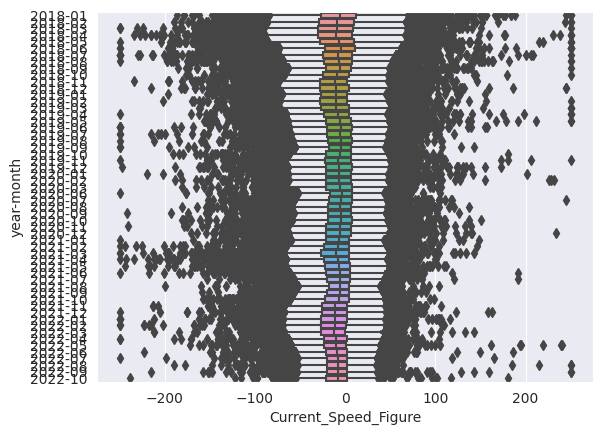

In [2]:
import seaborn as sns

COLUMN_NAME = "Current_Speed_Figure"
TIME_INTERVAL = "year-month"

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))

sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458
